# Introduction

Structured Query Language, or **SQL**, is the programming language used with databases. In this notebook, it's shown how to query SQL for stackoverflow data using **BigQuery**, a web service that lets you apply SQL to huge datasets.

To use BigQuery, we'll import the Python package below:

In [ ]:
from google.cloud import bigquery

In [ ]:
from google.colab import drive
# This will prompt for authorization.

drive.mount('/content/drive')

Mounted at /content/drive


The first step in the workflow is to create a [`Client`](https://google-cloud.readthedocs.io/en/latest/bigquery/generated/google.cloud.bigquery.client.Client.html#google.cloud.bigquery.client.Client) object.  As you'll soon see, this `Client` object will play a central role in retrieving information from BigQuery datasets.

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="GoogleSheetConnect-b417eb9921a8.json"

In [ ]:
# Create a "Client" object
client = bigquery.Client()

In BigQuery, each dataset is contained in a corresponding project.  In this case, our `stackoverflow` dataset is contained in the `bigquery-public-data` project.  To access the dataset, 
- We begin by constructing a reference to the dataset with the [`dataset()`](https://google-cloud.readthedocs.io/en/latest/bigquery/generated/google.cloud.bigquery.client.Client.dataset.html#google.cloud.bigquery.client.Client.dataset) method.  
- Next, we use the [`get_dataset()`](https://google-cloud.readthedocs.io/en/latest/bigquery/generated/google.cloud.bigquery.client.Client.get_dataset.html#google.cloud.bigquery.client.Client.get_dataset) method, along with the reference we just constructed, to fetch the dataset.

In [ ]:
# Construct a reference to the "stackoverflow" dataset
dataset_ref = client.dataset("stackoverflow", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

Every dataset is just a collection of tables.  You can think of a dataset as a spreadsheet file containing multiple tables, all composed of rows and columns.

We use the `list_tables()` method to list the tables in the dataset.

In [ ]:
# List all the tables in the "stackoverflow" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset (there are four!)
for table in tables:  
    print(table.table_id)

badges
comments
post_history
post_links
posts_answers
posts_moderator_nomination
posts_orphaned_tag_wiki
posts_privilege_wiki
posts_questions
posts_tag_wiki
posts_tag_wiki_excerpt
posts_wiki_placeholder
stackoverflow_posts
tags
users
votes


Similar to how we fetched a dataset, we can fetch a table.  In the code cell below, we fetch the `users` table in the `stackoverflow` dataset.

In [ ]:
# Construct a reference to the "full" table
table_ref = dataset_ref.table("users")

# API request - fetch the table
user_table = client.get_table(table_ref)

# Table schema

The structure of a table is called its **schema**.  We need to understand a table's schema to effectively pull out the data we want. 

In this example, we'll investigate the `users` table that we fetched above.

In [ ]:
# Print information on all the columns in the "users" table in the "stackoverflow" dataset
user_table.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('about_me', 'STRING', 'NULLABLE', None, ()),
 SchemaField('age', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_access_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('location', 'STRING', 'NULLABLE', None, ()),
 SchemaField('reputation', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('up_votes', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('down_votes', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('views', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('profile_image_url', 'STRING', 'NULLABLE', None, ()),
 SchemaField('website_url', 'STRING', 'NULLABLE', None, ())]

Each [`SchemaField`](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.schema.SchemaField.html#google.cloud.bigquery.schema.SchemaField) tells us about a specific column (which we also refer to as a **field**). In order, the information is:

* The **name** of the column
* The **field type** (or datatype) in the column
* The **mode** of the column (`'NULLABLE'` means that a column allows NULL values, and is the default)
* A **description** of the data in that column

We can use the [`list_rows()`](https://google-cloud.readthedocs.io/en/latest/bigquery/generated/google.cloud.bigquery.client.Client.list_rows.html#google.cloud.bigquery.client.Client.list_rows) method to check just the first five lines of the `users` table to make sure this is right. (Sometimes databases have outdated descriptions, so it's good to check.)  This returns a BigQuery [`RowIterator`](https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.table.RowIterator.html) object that can quickly be converted to a pandas DataFrame with the [`to_dataframe()`](https://google-cloud.readthedocs.io/en/latest/bigquery/generated/google.cloud.bigquery.table.RowIterator.to_dataframe.html) method.

# Table schema

The structure of a table is called its **schema**.  We need to understand a table's schema to effectively pull out the data we want. 

In this example, we'll investigate the `users` table that we fetched above.

# Querying for Stackoverflow users

We extract the id of users having been active within 2020, has a reputation above 10000, a public location and _about me_ section.

In [ ]:
# Your code here
users_query = """
                  SELECT
                  id, reputation, display_name, creation_date, location, last_access_date,
                  about_me, views, up_votes, down_votes

                  FROM 
                  `bigquery-public-data.stackoverflow.users`

                  WHERE last_access_date >= '2018-01-01 00:00:00' AND location IS NOT NULL
                     
                      
                  ORDER BY reputation DESC
                  """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
users_query_job = client.query(users_query, job_config=safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
users = users_query_job.to_dataframe() # Your code goes here

# Preview results
users.head()

,id,reputation,display_name,creation_date,location,last_access_date,about_me,views,up_votes,down_votes
0,22656,1206038,Jon Skeet,2008-09-26 12:05:05.150000+00:00,"Reading, United Kingdom",2020-09-05 17:32:07.613000+00:00,"<p>\nAuthor of <a href=""https://www.manning.co...",1972774,16633,7090
1,1144035,1006490,Gordon Linoff,2012-01-11 19:53:57.590000+00:00,"New York, United States",2020-09-06 02:21:13.123000+00:00,"<p>Check out my book <strong><em><a href=""http...",336960,17283,42
2,6309,979770,VonC,2008-09-13 22:22:33.173000+00:00,France,2020-09-06 05:10:37.823000+00:00,"<ul>\n<li><p><img src=""http://i.stack.imgur.co...",185652,56359,295
3,157882,949855,BalusC,2009-08-17 16:42:02.403000+00:00,"Willemstad, Curaçao",2020-09-05 23:05:35.913000+00:00,"<p>A <a href=""https://balusc.zeef.com"" rel=""no...",438873,15531,22108
4,29407,927319,Darin Dimitrov,2008-10-19 16:07:47.823000+00:00,"Sofia, Bulgaria",2020-09-03 10:50:38.807000+00:00,<p>I love writing code and I am really passion...,269811,1955,2651


In [ ]:
len(users)

2661635

In [ ]:
from google.colab import files
users.to_csv("complete_users.csv")
files.download("complete_users.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Querying for Questions posted on Stackoverflow




In [ ]:
# Construct a reference to the "posts_questions" table
table_ref = dataset_ref.table("posts_questions")

# API request - fetch the table
postsQ_table = client.get_table(table_ref)

In [ ]:
postsQ_table.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id'

In [ ]:
# Your code here
postsq_query = """
                  SELECT q.id, q.title, q.body, q.accepted_answer_id, q.answer_count, q.comment_count, q.owner_user_id,
                  q.score, q.tags, q.view_count

                  FROM
                  `bigquery-public-data.stackoverflow.posts_questions` as q
                  INNER JOIN
                  `bigquery-public-data.stackoverflow.users` as u
                  ON 
                  u.id = q.owner_user_id

                  WHERE q.creation_date >= '2019-01-01 00:00:00' AND q.accepted_answer_id IS NOT NULL 
                  AND q.view_count > 100 AND (q.tags LIKE 'python%' OR q.tags LIKE 'java%' OR q.tags LIKE 'c++'
                  OR q.tags LIKE '%sql' OR q.tags LIKE '.net' OR q.tags LIKE 'php' OR q.tags LIKE 'c#')                
                  """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 2 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=20**10)
postsq_query_job = client.query(postsq_query, job_config=safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
postsQ = postsq_query_job.to_dataframe() # Your code goes here

# Preview results
postsQ.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,owner_user_id,score,tags,view_count
0,57526029,NodeJS Instagram private API client in react JS,<p>I am facing an issue I am new in react and ...,57527975,1,0,7354214,-5,javascript|jquery|node.js|ajax|reactjs,358
1,59767726,why I have HTTP 403 from repo spring?,<p>I have a jhipster project which deploy on h...,60084538,3,2,1450740,13,java|spring|gitlab|jhipster,2659
2,57643277,Why does this method call on a null object run...,<p>What is the reason for the output? I know i...,57643309,4,0,8557287,11,java,459
3,57964817,Pass a function to a web worker that uses a we...,<p>I want to pass a simple function to a web w...,58120752,1,6,2032384,8,javascript|webpack|import|module|web-worker,389
4,60169996,"Does a ""with"" statement support type hinting?",<p>Can you define the type hint for a variable...,60170752,2,10,1031569,18,python|python-3.x|type-hinting,911


In [ ]:
len(postsQ)

145317

In [ ]:
set1 = set(users['id'])
set2 = set(postsQ['owner_user_id'])
len(set1.intersection(set2))

107772

# Query for Answers to Question on Stackoverflow

In [ ]:
# Construct a reference to the "posts_answers" table
table_ref = dataset_ref.table("posts_answers")

# API request - fetch the table
postsA_table = client.get_table(table_ref)

In [ ]:
postsA_table.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('title', 'STRING', 'NULLABLE', None, ()),
 SchemaField('body', 'STRING', 'NULLABLE', None, ()),
 SchemaField('accepted_answer_id', 'STRING', 'NULLABLE', None, ()),
 SchemaField('answer_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('comment_count', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('community_owned_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('favorite_count', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_activity_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_edit_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('last_editor_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('last_editor_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('owner_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('owner_user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('parent_id', '

In [ ]:
# Your code here
postsa_query = """
                  SELECT a.id, a.body, a.comment_count, a.owner_user_id, a.parent_id, a.score

                  FROM `bigquery-public-data.stackoverflow.posts_answers` as a
                  INNER JOIN `bigquery-public-data.stackoverflow.users` as u
                      ON u.id = a.owner_user_id
                  WHERE u.last_access_date >= '2020-08-01 00:00:00' AND u.reputation > 10000
                  AND u.location IS NOT NULL AND u.about_me IS NOT NULL 
                  """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 2 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=20**10)
postsa_query_job = client.query(postsa_query, job_config=safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
postsA = postsa_query_job.to_dataframe() # Your code goes here

# Preview results
postsA.head()

In [ ]:
len(postsA)

13621

In [ ]:
len(postsA["owner_user_id"].unique())

6400

In [ ]:
list1 = list(postsQ['id'])
list2 = list(postsA['parent_id'])

In [ ]:
results = {}
for i in list1:
        results[i] = list2.count(i)

In [ ]:
sum(results.values())

576

In [ ]:
set1 = set(postsQ['id'])
set2 = set(postsA['parent_id'])
len(set1.intersection(set2))

114

In [ ]:
import networkx as nx

In [ ]:
G = nx.DiGraph()
for ind in postsQ.index:
  for i in postsA[postsA['parent_id'] == postsQ["id"][ind]].index:
    if len(postsA[postsA['parent_id'] == postsQ["id"][ind]].index) > 1:
      G.add_edge(postsQ["owner_user_id"][ind],postsA["owner_user_id"][i])
    else: 
      pass

In [ ]:
G.number_of_nodes()

0

In [ ]:
G.number_of_edges()

0

In [ ]:
#Removing Isolates
for i in list(nx.isolates(G)):
    G.remove_node(i)

In [ ]:
#getting the largest connected network
largest_cc = max(nx.weakly_connected_components(G))

ValueError: ignored

In [ ]:
#creating the subgraph
G_1 = G.subgraph(largest_cc ).copy()

In [ ]:
# making graph undirected
G_2 = G_1.to_undirected()

In [ ]:
G_2.number_of_edges()

18

In [ ]:
G_2.number_of_nodes()

19

In [ ]:
#getting node size 
deg = []
for i in G_2.nodes():
    deg.append(G_2.degree[i])

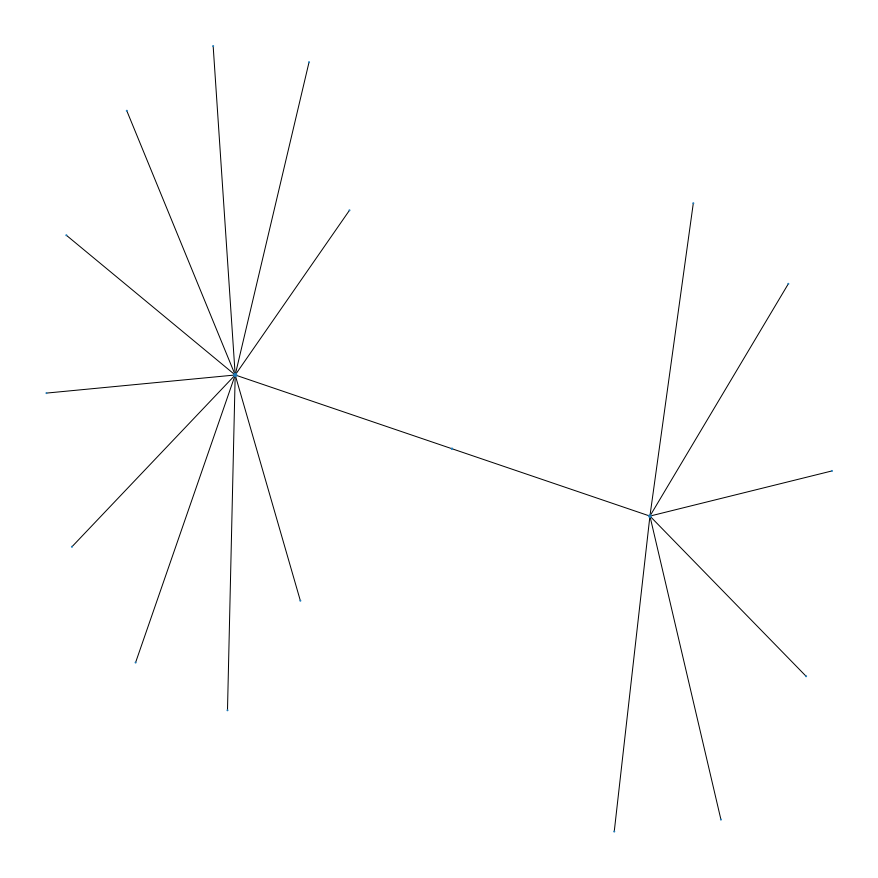

In [ ]:
import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(G_2)
plt.figure(3, figsize = (12,12))
#nodes = nx.draw_networkx_nodes(G_2, pos,node_size=10, node_color=res.values())
#nodes.set_edgecolor('#000000')
#nx.draw_networkx_edges(G_2, pos)
nx.draw(G_2,pos, node_size = deg)
plt.show()

# Query for Comments to Answers and Questions

In [ ]:
# Construct a reference to the "comments" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
comments_table = client.get_table(table_ref)

In [ ]:
comments_table.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('text', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, ())]

In [ ]:
# Your code here
comments_query = """
                  SELECT c.id, c.text, c.post_id, c.user_id, c.score

                  FROM
                  `bigquery-public-data.stackoverflow.comments` as c
                  INNER JOIN
                  `bigquery-public-data.stackoverflow.users` as u
                  ON 
                  u.id = c.user_id

                  WHERE u.last_access_date >= '2020-08-01 00:00:00' AND u.reputation > 10000 AND 
                        u.location IS NOT NULL AND u.about_me IS NOT NULL                
                  """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 2 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=20**10)
comments_query_job = client.query(comments_query, job_config=safe_config) # Your code goes here

# API request - run the query, and return a pandas DataFrame
comments = comments_query_job.to_dataframe() # Your code goes here

# Preview results
comments.head()

# Concatenate tables with Union

In [ ]:
postsA.dtypes

id                int64
body             object
comment_count     int64
owner_user_id     int64
parent_id         int64
score             int64
dtype: object

In [ ]:
postsQ = postsQ.dropna()
postsQ['owner_user_id'] = postsQ['owner_user_id'].astype(int)
postsQ.head()

,id,title,accepted_answer_id,answer_count,comment_count,owner_user_id,score,tags,view_count
0,63560005,Draw curved lines to connect points in matplotlib,63561363,2,0,8995741,18,python|matplotlib,317
1,63565720,Check if number is divisible by a power of two,63565849,3,0,1129332,-12,java|algorithm|bit-manipulation,113
2,63443583,Seaborn ValueError: zero-size array to reducti...,63640434,2,0,5318986,10,python|pandas|seaborn,1213
3,63663362,"Django, python3, on install I get: ""Parent mod...",63668592,5,0,971529,13,python|django|pip|virtualenv|setuptools,3558
4,63727290,Why doesn't Python give any error when quotes ...,63727364,3,1,14215946,27,python|python-3.x|string|quotes,2305


In [ ]:
users_dict = users.set_index('id').to_dict('index')
question = postsQ.set_index('id').to_dict('index')
answers = postsA.set_index('id').to_dict('index')

In [ ]:
question[61478227]

KeyError: ignored

In [ ]:
links = dict()

for index, row in postsA.iterrows():
  if row['owner_user_id'] in users_dict.keys():
    if row['owner_user_id'] in links.keys():
      links[row['owner_user_id']].append(question[row['parent_id']]['owner_user_id'])
    else:
      if row['parent_id'] in question.keys():
        links[row['owner_user_id']] = [question[row['parent_id']]['owner_user_id']]

KeyError: ignored

In [ ]:
len(data_dump)

11340

In [ ]:
postsA.sort_values('score', ascending=False)

,id,body,comment_count,owner_user_id,parent_id,score
187928,48270314,"<p>If you take advantage of <a href=""https://d...",19,400654.0,48270127,3348
187873,48274520,<p>I couldn't resist - the other answers are u...,13,781965.0,48270127,2066
505661,53453588,<p>There is a slight difference in the orderin...,22,485343.0,53452713,1209
332773,49836753,<p>You must have inadvertently upgraded your s...,12,812183.0,49836676,853
147543,52524114,<p><strong>Note:</strong> <em>These solutions ...,21,3679676.0,52524112,762
...,...,...,...,...,...,...
302264,55823425,<p>One of the simple ideas is to replace the s...,4,6043244.0,55823298,-10
89303,50920268,<p>This simple example uses a Regular Expressi...,1,4356188.0,50920180,-11
64799,57161892,<p>The error is due to JRE incompatibility. Lo...,2,11824054.0,55272870,-12
500213,53409107,"<p>As mentioned by other people, you would nee...",2,7488236.0,53389956,-19


In [ ]:
# Construct a reference to the "full" table
table_ref = dataset_ref.table("comments")

# API request - fetch the table
comments_table = client.get_table(table_ref)

In [ ]:
comments_table.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('text', 'STRING', 'NULLABLE', None, ()),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, ()),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, ()),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, ())]

In [ ]:
#len(comments)

The `list_rows()` method will also let us look at just the information in a specific column. If we want to see the first five entries in the `by` column, for example, we can do that!

In [ ]:
postsA = postsA.fillna(0)
postsA.drop(index=postsA[postsA['owner_user_id'] == 0].index, inplace=True)
postsA['owner_user_id'] = postsA['owner_user_id'].astype(int)
unique_parents = postsA["parent_id"].unique()

In [ ]:
postQ = postsQ.fillna(0)
postsQ.drop(index=postsQ[postsQ['owner_user_id'] == 0].index, inplace=True)

In [ ]:
len(unique_parents )


325189

In [ ]:
for ind in postsA[postsA['parent_id'] == 63560005].index:
  print(ind)

20518
20611


In [ ]:
import numpy as np 
import pandas as pd
import re
import requests
from random import choice
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2

In [ ]:
G = nx.DiGraph()
for ind in postsQ.index:
  parent_id = postsQ["id"][ind]
  parent_user_id = postsQ["owner_user_id"][ind]
  G.add_node(postsQ["owner_user_id"][ind], Name = postsQ["owner_user_id"][ind])
  for i in postsA[postsA['parent_id'] == postsQ["id"][ind]].index:
    G.add_edge(postsQ["owner_user_id"][ind],postsA["owner_user_id"][i])




In [ ]:
#Removing Isolates
for i in list(nx.isolates(G)):
    G.remove_node(i)

In [ ]:
#getting the largest connected network
largest_cc = max(nx.weakly_connected_components(G))
len(largest_cc)

269173

In [ ]:
#creating the subgraph
G_1 = G.subgraph(largest_cc ).copy()

In [ ]:
# making graph undirected
G_2 = G_1.to_undirected()



In [ ]:
G_2.number_of_edges()


498282

In [ ]:
G_2.number_of_nodes()

269173

In [ ]:
#getting node size 
deg = []
for i in G_2.nodes():
    deg.append(G_2.degree[i])

(array([2.66105e+05, 1.95200e+03, 5.17000e+02, 2.11000e+02, 9.60000e+01,
        7.70000e+01, 4.30000e+01, 3.00000e+01, 1.90000e+01, 1.80000e+01,
        1.40000e+01, 1.00000e+01, 9.00000e+00, 8.00000e+00, 9.00000e+00,
        1.10000e+01, 5.00000e+00, 6.00000e+00, 3.00000e+00, 6.00000e+00,
        2.00000e+00, 2.00000e+00, 3.00000e+00, 0.00000e+00, 2.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

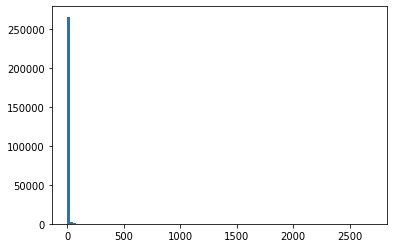

In [ ]:
plt.bar(G_2.nodes(), deg)

In [ ]:
pos = nx.kamada_kawai_layout(G_2)
plt.figure(3, figsize = (12,12))
#nodes = nx.draw_networkx_nodes(G_2, pos,node_size=10, node_color=res.values())
#nodes.set_edgecolor('#000000')
#nx.draw_networkx_edges(G_2, pos)
nx.draw(G_2,pos, node_size = deg)
plt.show()

KeyboardInterrupt: ignored

In [ ]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.5,
                        # Performance
                        jitterTolerance=2,  # Tolerance
                        barnesHutOptimize=False,
                        barnesHutTheta=.5,
                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=0.1,
                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_2, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_2, positions, node_size=deg, node_color=color_map)
nx.draw_networkx_edges(G_2, positions, edge_color="yellow", alpha=0.5, width=0.1)
plt.rcParams["figure.figsize"] = [40,40]
plt.axis('off')
plt.show()

In [ ]:
# Preview the first five entries in the "by" column of the "full" table
client.list_rows(table, selected_fields=table.schema[:1], max_results=5).to_dataframe()

# Disclaimer
Before we go into the coding exercise, a quick disclaimer for those who already know some SQL:

**Each Kaggle user can scan 5TB every 30 days for free.  Once you hit that limit, you'll have to wait for it to reset.**

The commands you've seen so far won't demand a meaningful fraction of that limit. But some BiqQuery datasets are huge. So, if you already know SQL, wait to run SELECT queries until you've seen how to use your allotment effectively. If you are like most people reading this, you don't know how to write these queries yet, so you don't need to worry about this disclaimer.


---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161314) to chat with other Learners.*